In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pytensor.tensor as pt
from scipy.stats import norm, beta, lognorm


## Q1

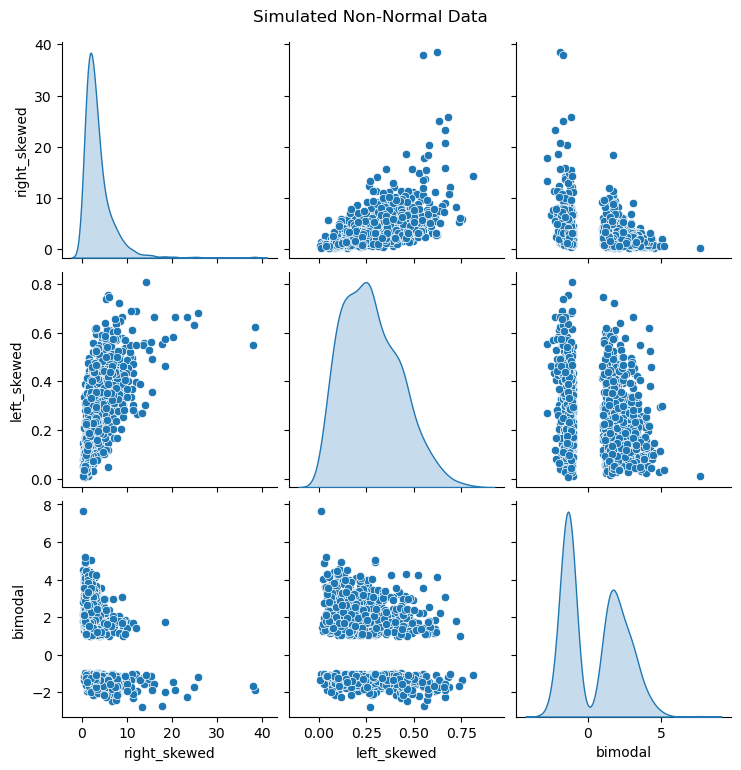

In [2]:

# Generating data

# Set random seed for reproducibility
np.random.seed(42)

# Number of observations
n = 1000

# Generating correlated normal variables (latent variables)
corr_matrix = np.array([
    [1.0, 0.7, -0.5],
    [0.7, 1.0, -0.3],
    [-0.5, -0.3, 1.0]
])

# Generating multivariate normal data
latent_data = np.random.multivariate_normal(
    mean=[0, 0, 0],
    cov=corr_matrix,
    size=n
)

# Transforming to non-normal marginals
# 1. Right-skewed (lognormal)
x1 = np.exp(latent_data[:, 0] * 0.8 + 1)

# 2. Left-skewed (beta)
x2 = beta.ppf(
    norm.cdf(latent_data[:, 1]),
    a=2, b=5
)

# 3. Bimodal (mixture of normals)
x3 = np.where(
    latent_data[:, 2] > 0,
    latent_data[:, 2] * 1.5 + 1,
    latent_data[:, 2] * 0.5 - 1
)

# Combining into a dataframe
data = pd.DataFrame({
    'right_skewed': x1,
    'left_skewed': x2,
    'bimodal': x3
})

# Plotting the data
sns.pairplot(data, diag_kind='kde')
plt.suptitle('Simulated Non-Normal Data', y=1.02)
plt.show()

**Pass 1: Estimate the marginal distributions**

In [3]:
def estimate_marginals(data):
    """
    Estimate marginal distributions for each variable
    Returns empirical CDF functions for each variable
    """
    from statsmodels.distributions.empirical_distribution import ECDF
    
    marginals = {}
    for col in data.columns:
        marginals[col] = ECDF(data[col])
    return marginals

marginals = estimate_marginals(data)

**pass 2: Build the Copula model with pymc**

In [5]:

# Transforming data to uniform scale using empirical CDFs
uniform_data = pd.DataFrame({
    col: marginals[col](data[col]) for col in data.columns
})

# 1. Transforming to uniform data (with boundary protection)
uniform_data = np.column_stack([marginals[col](data[col]) for col in data.columns])

# 2. Clipping to avoid 0 and 1 exactly
uniform_data = np.clip(uniform_data, 1e-9, 1-1e-9)


# For modeling, we transform uniform to normal (inverse probit)
normal_scores = norm.ppf(uniform_data)

#Verifying no infs/nans
print(f"NaNs: {np.isnan(normal_scores).sum()}, Infs: {np.isinf(normal_scores).sum()}")


# Ensuring the data has the right shape
print(f"Normal scores shape: {normal_scores.shape}")  # Should be (n_samples, n_vars)

with pm.Model() as copula_model:
    # LKJCholeskyCov returns (chol, corr, stds)
    chol, corr, stds = pm.LKJCholeskyCov(
        'chol_cov',
        n=len(data.columns),
        eta=2,
        sd_dist=pm.HalfNormal.dist(1.0)
    )
    
    # Tracking the correlation matrix
    pm.Deterministic('corr', corr)
    
    # Multivariate normal likelihood
    mv_normal = pm.MvNormal(
        'mv_normal',
        mu=np.zeros(len(data.columns)),
        chol=chol,
        observed=normal_scores
    )
    
    # Sampling from the posterior
    trace = pm.sample(
        2000, 
        tune=1000, 
        chains=4, 
        target_accept=0.9,
        random_seed=42
    )



NaNs: 0, Infs: 0
Normal scores shape: (1000, 3)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 156 seconds.


In [6]:
# Check the results
az.summary(trace, var_names=['corr'], round_to = 5)

/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"corr[0, 0]",1.00000,0.00000,1.00000,1.00000,0.00000,NaN,8000.00000,8000.00000,NaN
"corr[0, 1]",0.66968,0.01749,0.63706,0.70218,0.00017,0.00019,10328.40621,6719.70750,1.00041
"corr[0, 2]",-0.50513,0.02360,-0.54960,-0.46186,0.00024,0.00029,9636.84317,5802.93269,1.00031
"corr[1, 0]",0.66968,0.01749,0.63706,0.70218,0.00017,0.00019,10328.40621,6719.70750,1.00041
"corr[1, 1]",1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,7925.36873,8000.00000,1.00008
"corr[1, 2]",-0.26527,0.02981,-0.32087,-0.21009,0.00029,0.00033,10283.45568,6103.79168,1.00026
"corr[2, 0]",-0.50513,0.02360,-0.54960,-0.46186,0.00024,0.00029,9636.84317,5802.93269,1.00031
"corr[2, 1]",-0.26527,0.02981,-0.32087,-0.21009,0.00029,0.00033,10283.45568,6103.79168,1.00026
"corr[2, 2]",1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,7774.68636,7599.14650,1.00057


As we can observe, the correlation parameters as part of the covariance matrix all have an effective sample size bulk of more than 50% of the total number of iterations. This means that the dependency structure has been overcome i.e the stationary distribution has been reached. The r hats are also below 1.01 for all parameters suggesting that convergence has also been reached. for the correlation coefficient at index 0,0 we see a NaN value which implies that there were some convergence problems there. the rest of the coefficients are fine.



Subquestion 3:**Describe what a copula is and how the two verions of code implement it**

**Definition**

A copula is a multivariate probability distribution function that links (or "couples") the marginal distributions of p random variables to their joint distribution. This is particularly useful when the correlation structure between the random variables is complex. 

The two coupula codes specificed differ in method. One of them is a 'single' pass Copula whereas the one we implemented is a double pass copula.

**double pass**

In a double-pass copula (like the one we did) we parametrically estimate our marginal distributions and their empricial CDF's. This is the first step. Then, we apply a uniform transformation after which we apply the probit transformation(inverse Normal CDF). This is done to acquire the covariannce parameter of the coupula.

**single pass**

In a single-pass case, we do not separately estimate the parameters of the marginal distribution. Instead, we jointly estimate the covariance parameter of the copula. Here, we directly apply the multinormal distribution on the probit transformed data. There are no intermediary transformations like the uniform transformation (since we don't have parametric marginal distributions). 



subquestion 4:**Describe how to use this to create arbitrary multivariate GLM regressions**

Copulas provide a powerful framework for building multivariate GLMs by decoupling the modeling of marginal distributions from the dependence structure. 

1. Model specification

First, define separate GLMs for each outcome variable's marginal distribution. Each GLM can have:

- Different link functions (logit, log, etc.)

- Different predictor sets

- Different distributional families (Binomial, Poisson, Gamma, etc.)

The key insight is that copulas allow these marginal models to be combined while preserving their individual characteristics.


2. Dependence Modeling

After specifying marginals, model the dependence structure using a copula:

Transform each marginal outcome to uniform scale using its CDF

Specify a copula function (Gaussian, t, vine, etc.) on these uniforms

The copula parameters capture dependence between outcomes





## Q2

In [7]:
# random seed for reproducibility
np.random.seed(42)

In [8]:
#synthetic data generation
# Parameters
n_obs = 100
n_predictors = 5
n_outcomes = 2
true_active_predictors = [0, 3, 4]  # indices of truly active predictors

# Generating design matrix
X = np.random.normal(size=(n_obs, n_predictors))
X[:, 0] = 1  # intercept

# True coefficients (only some predictors are active)
true_beta = np.zeros((n_predictors, n_outcomes))
true_beta[true_active_predictors, :] = np.array([[1.5, -2.0],  # predictor 0 (intercept)
                                                 [0.8, 1.2],   # predictor 3
                                                 [-1.0, 0.5]]) # predictor 4

# Generating outcomes with noise
noise_scale = 0.5
noise = np.random.normal(scale=noise_scale, size=(n_obs, n_outcomes))
Y = X @ true_beta + noise

# Standardizing data (except intercept)
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[:, 1:] = scaler.fit_transform(X[:, 1:])

In [9]:
# Model 1 is of Diffused normal priors with minimal L2 regularization

with pm.Model() as diffuse_model:
    # Diffuse normal priors for coefficients
    beta = pm.Normal("beta", mu=0, sigma=10, shape=(n_predictors, n_outcomes))
    
    # Covariance matrix for multivariate normal likelihood
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=n_outcomes, eta=1, 
        sd_dist=pm.Exponential.dist(lam=1.0), compute_corr=True
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    
    # Expected value
    mu = pm.math.dot(X_scaled, beta)
    
    # Likelihood
    Y_obs = pm.MvNormal("Y_obs", mu=mu, chol=chol, observed=Y)
    
    # Sample
    diffuse_trace = pm.sample(2000, tune=1000, chains=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, chol]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 99 seconds.


In [10]:
# model 2 is of the spike and slab prior
with pm.Model() as spike_and_slab:
    # Shared inclusion probability for each predictor (shape: n_predictors)
    p = pm.Beta('p', alpha=1, beta=1, shape=n_predictors)
    
    # Inclusion indicators - shape (n_predictors,)
    spike = pm.Bernoulli('spike', p=p, shape=n_predictors)
    
    # Coefficient values - shape (n_predictors, n_outcomes)
    slab = pm.Normal('slab', mu=0, sigma=10, shape=(n_predictors, n_outcomes))
    
    # Proper broadcasting using dimshuffle (PyMC's equivalent of reshape)
    spike_reshaped = spike.dimshuffle(0, 'x')  # Converts (n_predictors,) to (n_predictors, 1)
    
    # Actual coefficients
    beta = pm.Deterministic('beta', spike_reshaped * slab)
    
    # Covariance matrix for multivariate normal
    chol, corr, stds = pm.LKJCholeskyCov(
        'chol', n=n_outcomes, eta=1,
        sd_dist=pm.Exponential.dist(lam=1.0), compute_corr=True
    )
    cov = pm.Deterministic('cov', chol.dot(chol.T))
    
    # Expected value of outcomes
    mu = pm.math.dot(X_scaled, beta)
    
    # Likelihood
    Y_obs = pm.MvNormal('Y_obs', mu=mu, chol=chol, observed=Y)
    
    # Sampling
    idata = pm.sample(2000, tune=1000, chains=2, target_accept=0.9)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [p, slab, chol]
>BinaryGibbsMetropolis: [spike]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 178 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


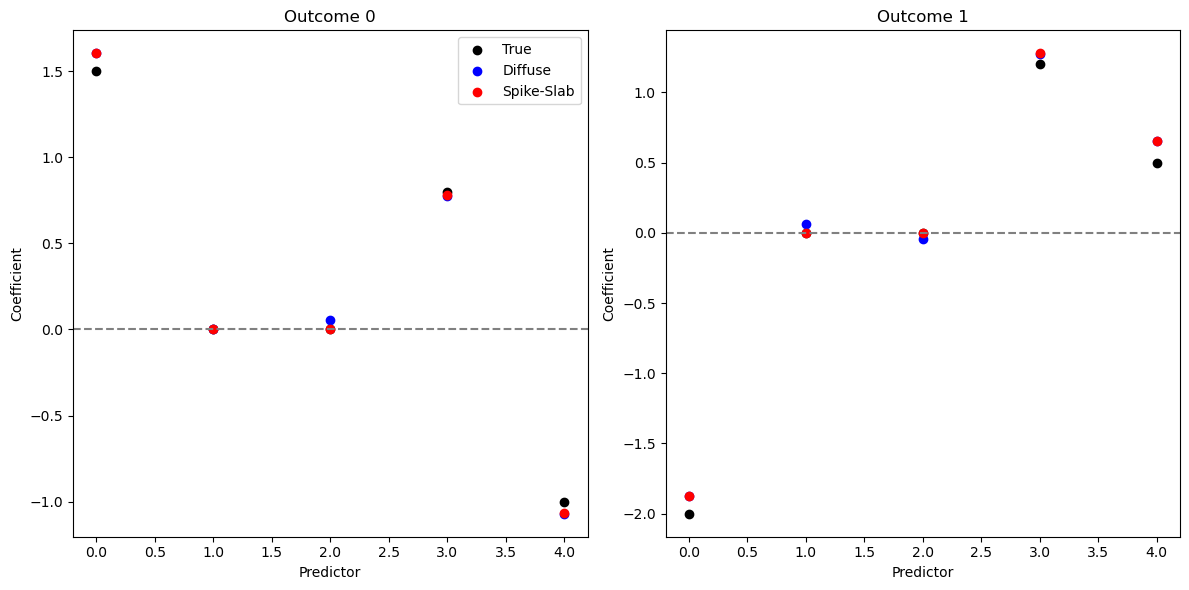

In [11]:
# comparing beta coefficients
diffuse_beta = diffuse_trace.posterior["beta"].mean(dim=("chain", "draw"))
spike_slab_beta = idata.posterior["beta"].mean(dim=("chain", "draw"))

# comparison DataFrame
results = pd.DataFrame({
    "Predictor": np.repeat(np.arange(n_predictors), n_outcomes),
    "Outcome": np.tile(np.arange(n_outcomes), n_predictors),
    "True": true_beta.flatten(),
    "Diffuse": diffuse_beta.values.flatten(),
    "SpikeSlab": spike_slab_beta.values.flatten()
})

# ploting comparison
plt.figure(figsize=(12, 6))
for i, outcome in enumerate(range(n_outcomes)):
    plt.subplot(1, n_outcomes, i+1)
    subset = results[results["Outcome"] == outcome]
    plt.scatter(subset["Predictor"], subset["True"], color='black', label='True')
    plt.scatter(subset["Predictor"], subset["Diffuse"], color='blue', label='Diffuse')
    plt.scatter(subset["Predictor"], subset["SpikeSlab"], color='red', label='Spike-Slab')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"Outcome {i}")
    plt.xlabel("Predictor")
    plt.ylabel("Coefficient")
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()



The following are the true and estimated coefficients of our spike-and-slab modela and diffuse model.



**outcome 0 analysis**

We can see that for outcome 0, we have 5 predictors with 3 significant predictors and 2 insignificant ones. This is how the data was simulated in the first place. For predictor 1, we see that the spike-and-slab model slightly overestimates the coefficient but is still close to the true coefficient at 1.5. Interestingly enough, our diffused model coefficient perfectly overlaps the spike-and-slab estimate. For predictors 2 and 3 (which are insignificant to the model) the spike-and-slab estimates are at zero which is in line with our data generation process. The diffuse model, however, fails to shrink the third predictor completely to zero. Moreover, For the remaining two predictors, the spike-and-slab estimate closely estimates the true value with a slight error. Again, the coefficients almost perfectly overlap with our diffused model coefficients. Overall, when it comes to variable selection the spike-and-slab model was able to shrink our insignificant predictors to zero which is a good result. For the diffused model, it correctly estimates the true value in line with spike-and-slab estimates for the significant predictors but cannot completely shrink the insignificant predictors's coefficients to zero.

**outcome 1 analysis**

Again, for our insignificant predictors 2 and 3 the spike and slab is able to shrink them to zero. For the remaining three significant predictors the spike-and-slab model overestimates the coefficient value. Interestingly enough, it almost perfectly overlaps with the diffuse model coefficients suggesting similar convergence results for those parameters specifically. For the insignificant predictors, the diffuse model yet again does not shrink the coefficient completely to zero. This seems to be a trend where the spike-and-slab shrinks to zero where the diffuse cannot do it fully. 


**overall conclusion**

we can conclude that the spike and slab prior model does a better job at shrinkage/variable selection overall compared to the diffused prior model. When it comes to significant predictors, both methods perform the same. We can also say that the two methods do a better job for outcome 0 than outcome 1. 



## Q3

In [12]:
# Horshoe prior model
with pm.Model() as hs_model:
    # Global shrinkage parameter
    tau = pm.HalfCauchy("tau", beta=1)
    
    # Local shrinkage parameters
    lam = pm.HalfCauchy("lam", beta=1, shape=n_predictors)
    
    # Shrunken coefficients
    beta_raw = pm.Normal("beta_raw", mu=0, sigma=1, shape=(n_predictors, n_outcomes))
    beta = pm.Deterministic("beta", tau * lam[:, None] * beta_raw)
    
    # Covariance matrix
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=n_outcomes, eta=1,
        sd_dist=pm.Exponential.dist(lam=1.0), compute_corr=True
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    
    # Likelihood
    mu = pm.math.dot(X_scaled, beta)
    Y_obs = pm.MvNormal("Y_obs", mu=mu, chol=chol, observed=Y)
    
    # Sampling
    hs_trace = pm.sample(2000,tune=1000, chains=2, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tau, lam, beta_raw, chol]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1921 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


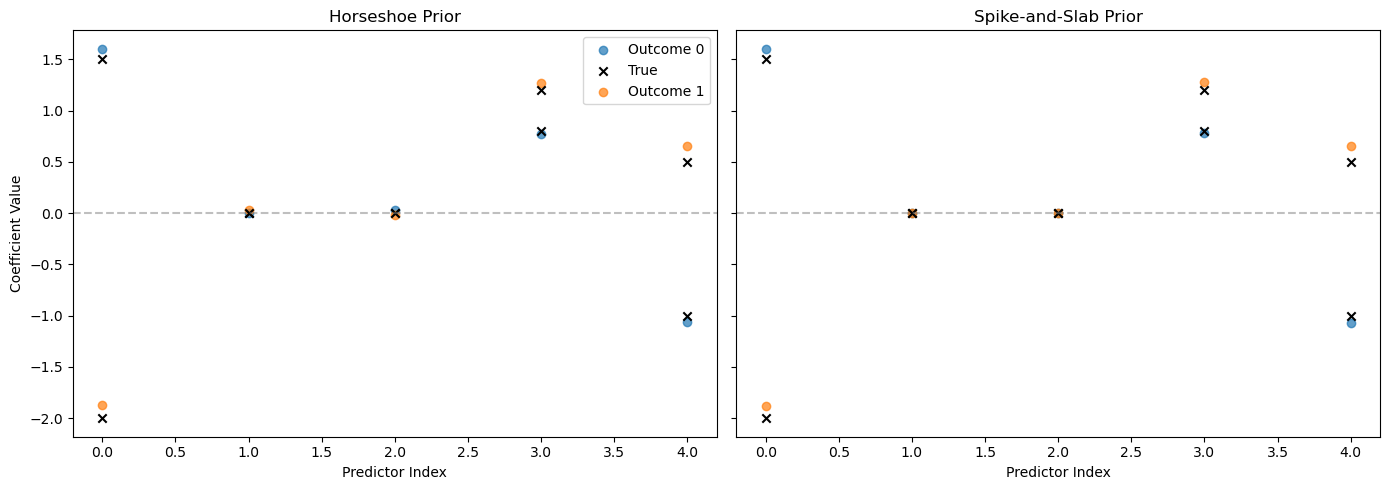

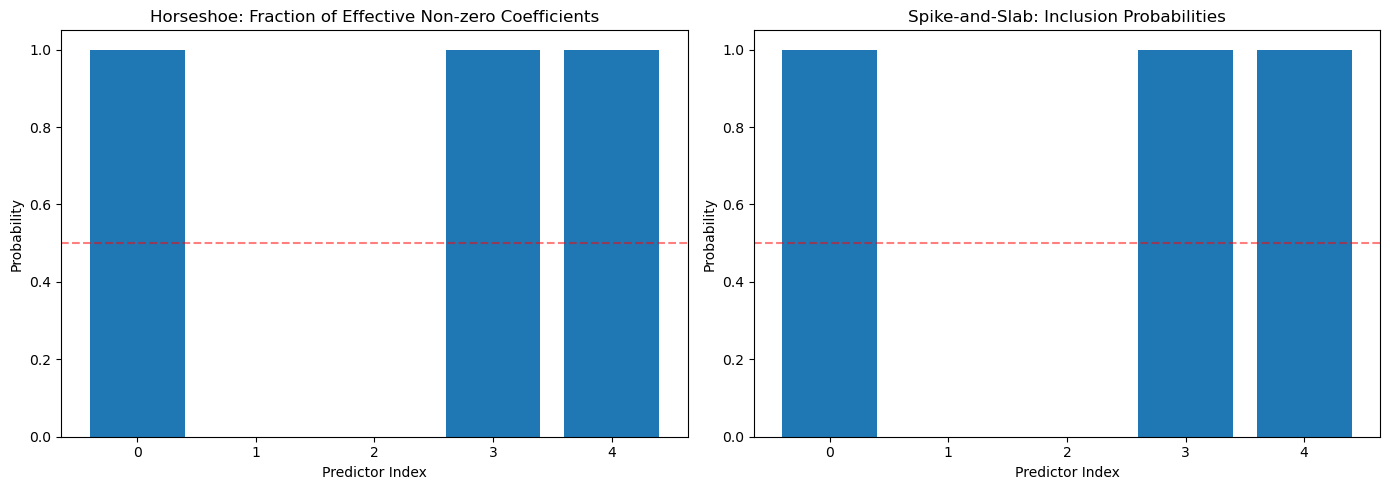

In [16]:
# Extract posterior means
hs_beta = hs_trace.posterior["beta"].mean(dim=("chain", "draw"))
ss_beta = idata.posterior["beta"].mean(dim=("chain", "draw"))

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for outcome in range(n_outcomes):
    axes[0].scatter(range(n_predictors), hs_beta[:,outcome], 
                   label=f"Outcome {outcome}", alpha=0.7)
    axes[1].scatter(range(n_predictors), ss_beta[:,outcome],
                   label=f"Outcome {outcome}", alpha=0.7)
    
    # Plot true values
    axes[0].scatter(range(n_predictors), true_beta[:,outcome], 
                   color='black', marker='x', label='True' if outcome==0 else None)
    axes[1].scatter(range(n_predictors), true_beta[:,outcome],
                   color='black', marker='x', label='True' if outcome==0 else None)

axes[0].set_title("Horseshoe Prior")
axes[1].set_title("Spike-and-Slab Prior")
axes[0].set_ylabel("Coefficient Value")
axes[0].set_xlabel("Predictor Index")
axes[1].set_xlabel("Predictor Index")
axes[0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[1].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[0].legend()
plt.tight_layout()
plt.show()

# Compare variable selection
hs_effective_nonzero = (np.abs(hs_trace.posterior["beta"].mean(dim=("chain", "draw")))) > 0.1
ss_inclusion_probs = idata.posterior["spike"].mean(dim=("chain", "draw"))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(range(n_predictors), hs_effective_nonzero.mean(axis=1))
axes[0].set_title("Horseshoe: Fraction of Effective Non-zero Coefficients")
axes[1].bar(range(n_predictors), ss_inclusion_probs)
axes[1].set_title("Spike-and-Slab: Inclusion Probabilities")
for ax in axes:
    ax.set_xlabel("Predictor Index")
    ax.set_ylabel("Probability")
    ax.axhline(0.5, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The first two plots compare the results of the horseshoe and spike-and-slab priors

**analysis**

for predictor 1, the horshoe prior models' prediction of outcome 0 and outcome 1 slightly deviate from the true value. This deviation is much lesser for predictor 4 and 5 but nonetheless present. For our insignificant predictors, our model coefficients perfectly align with the true outcome which is at zero. Interestingly, the inference of the horseshoe prior almost perfectly matches that of the spike-and-slab prior. In terms of srhinkage, both prior models succesfully reduce predictor coefficients to zero for the insignificant predictors 2 and 3.

Moreover, when we look at the comparison of inclusion probabilities (beta-binomial of spike-slab model) with the fraction of non-zero coefficients for the horseshoe model, they pretty much perfectly align. In other words, predictors 2 and 3 (1 and 2) have a zero inclusion probability while the other coefficients have non-zero probabilities which matches with the results of the horseshoe prior. 

To conclude, it seems like the horseshoe prior and spike-and-slab prior behave in almost the exact same way when it comes to variable selection and shrinkage.

*One explanation of this can be that both priors have the same objective which is 'sparse signal recovery'. this means that the models objective is to give accurate inference when the true model is very sparse (few active predictors) which is exactly the case in our simulated data.*